In [1]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import AdaBelief


# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
 # 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1
!pip install pystan~=2.14
!pip install plotly


# matplotlib日本語化対応
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61975553 sha256=ff5dcf626574da55fb10fff347305f0013dd7867c15692c044d4796be180be3a
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan


1209
1204    2023/5/4
1205    2023/5/5
1206    2023/5/6
1207    2023/5/7
1208    2023/5/8
Name: Date, dtype: object
[1 0 0 0 0]


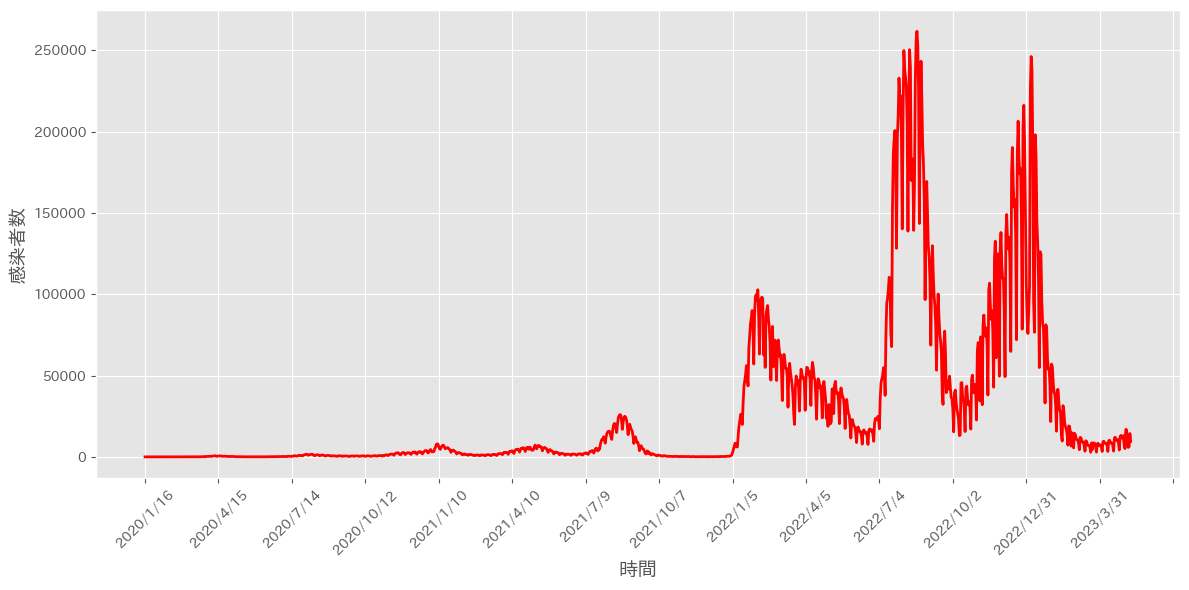

In [4]:
#ファイルの読込み
df = pd.read_csv('newly_confirmed_cases_daily.csv', encoding='utf-8', skiprows=0)
month = df.iloc[:, 0]
print(len(month))
print(month[-5:])

data = df.iloc[:, 1]
data = data.values
print(data[:5])


# 折れ線グラフを描画
plt.figure(figsize=(12, 6))
plt.xticks(np.arange(0, 1300, step=90))
plt.plot(month, data, color='r', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('時間', fontsize=14)
plt.ylabel('感染者数', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

In [5]:
#0〜1にスケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(data)
print(data)
df_scale = pd.DataFrame(scaler.fit_transform(data), index = data.index, columns=data.columns)
print(data.columns)

          0
0         1
1         0
2         0
3         0
4         0
...     ...
1204   7303
1205   5793
1206   6257
1207  14344
1208   9489

[1209 rows x 1 columns]
RangeIndex(start=0, stop=1, step=1)


In [6]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータの分別
train_data, test_data = train_test_split(df_scale, test_size=0.2, shuffle=False)

print("学習データ:")
print(train_data[:5])
print("\nテストデータ:")
print(test_data[:5])



学習データ:
          0
0  0.000004
1  0.000000
2  0.000000
3  0.000000
4  0.000000

テストデータ:
            0
967  0.379857
968  0.353564
969  0.310715
970  0.203695
971  0.333815


In [7]:
look_back = 7 #どれくらい過去まで見るか

def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)


Epoch 1/150
960/960 [==============================] - 18s 11ms/step - loss: 0.0068
Epoch 2/150
960/960 [==============================] - 11s 11ms/step - loss: 0.0026
Epoch 3/150
960/960 [==============================] - 11s 12ms/step - loss: 0.0025
Epoch 4/150
960/960 [==============================] - 9s 9ms/step - loss: 0.0023
Epoch 5/150
960/960 [==============================] - 6s 6ms/step - loss: 0.0025
Epoch 6/150
960/960 [==============================] - 7s 7ms/step - loss: 0.0024
Epoch 7/150
960/960 [==============================] - 6s 6ms/step - loss: 0.0024
Epoch 8/150
960/960 [==============================] - 7s 7ms/step - loss: 0.0024
Epoch 9/150
960/960 [==============================] - 5s 6ms/step - loss: 0.0022
Epoch 10/150
960/960 [==============================] - 6s 6ms/step - loss: 0.0023
Epoch 11/150
960/960 [==============================] - 6s 6ms/step - loss: 0.0022
Epoch 12/150
960/960 [==============================] - 6s 7ms/step - loss: 0.0021
Epoch 1

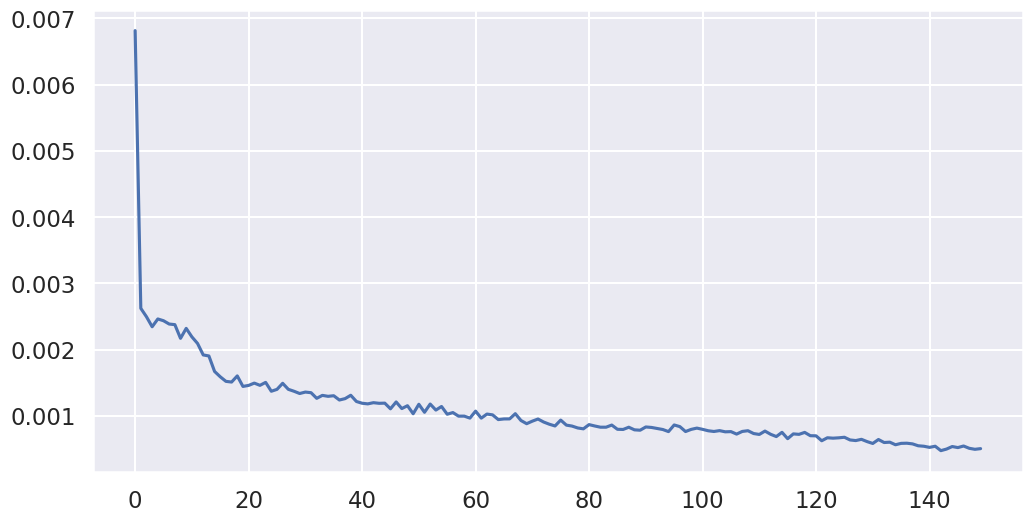

In [8]:
model = Sequential()
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(8))
model.add(Dense(len(data.columns))) #出力層はデータ数に合わせる
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=150, batch_size=1)

sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])


精度の確認:
8/8 [==============================] - 1s 4ms/step
テストデータに対するMAPE: 0.3787049672726858
8/8 [==============================] - 0s 5ms/step


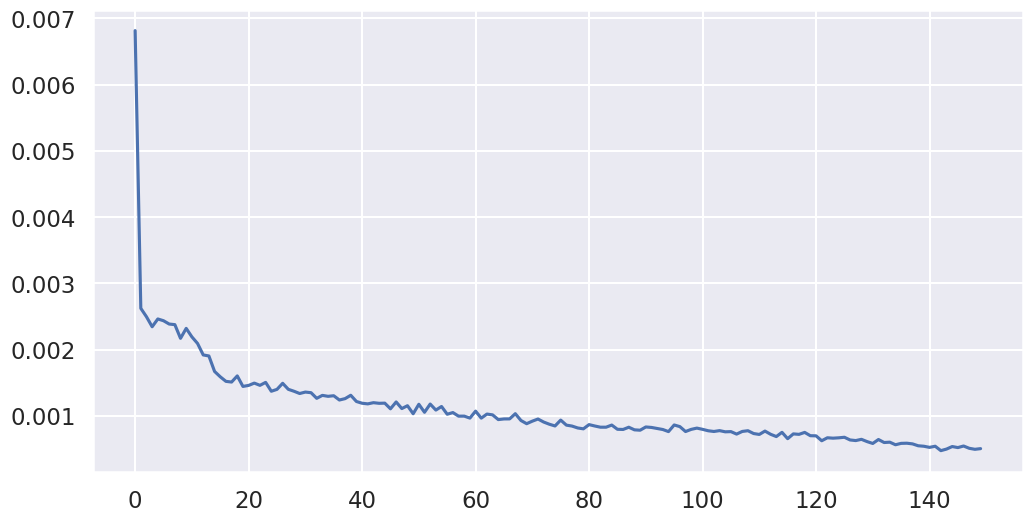

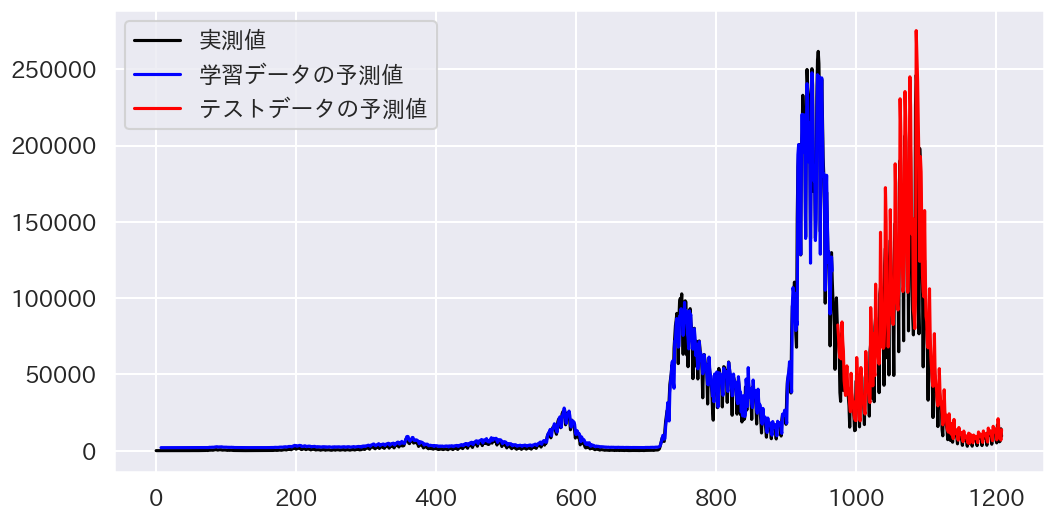

In [9]:
#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-7])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])





import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()


Epoch 1/100
960/960 [==============================] - 21s 11ms/step - loss: 0.0075
Epoch 2/100
960/960 [==============================] - 10s 10ms/step - loss: 0.0026
Epoch 3/100
960/960 [==============================] - 8s 8ms/step - loss: 0.0025
Epoch 4/100
960/960 [==============================] - 6s 6ms/step - loss: 0.0024
Epoch 5/100
960/960 [==============================] - 7s 7ms/step - loss: 0.0024
Epoch 6/100
960/960 [==============================] - 6s 6ms/step - loss: 0.0023
Epoch 7/100
960/960 [==============================] - 7s 7ms/step - loss: 0.0023
Epoch 8/100
960/960 [==============================] - 6s 6ms/step - loss: 0.0023
Epoch 9/100
960/960 [==============================] - 7s 7ms/step - loss: 0.0023
Epoch 10/100
960/960 [==============================] - 6s 6ms/step - loss: 0.0022
Epoch 11/100
960/960 [==============================] - 6s 6ms/step - loss: 0.0024
Epoch 12/100
960/960 [==============================] - 6s 6ms/step - loss: 0.0022
Epoch 13/

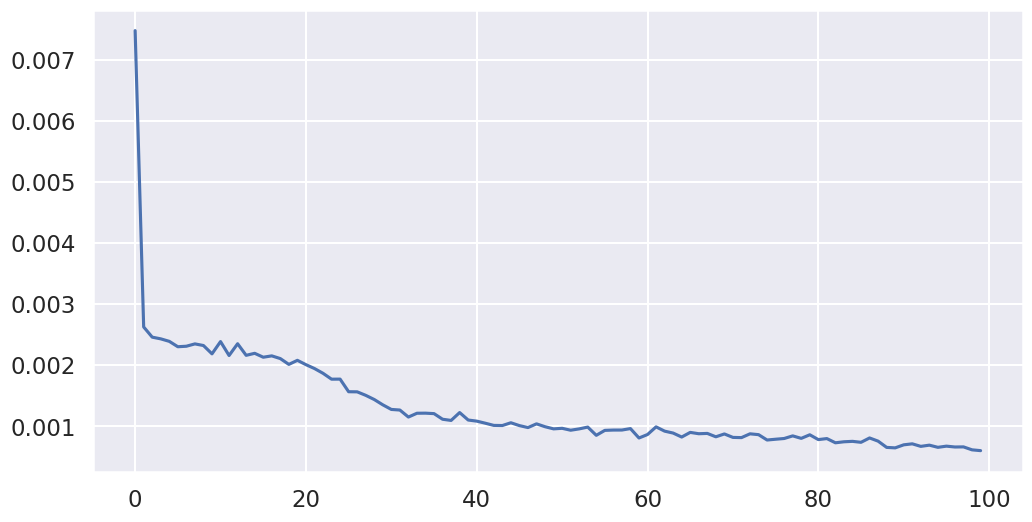

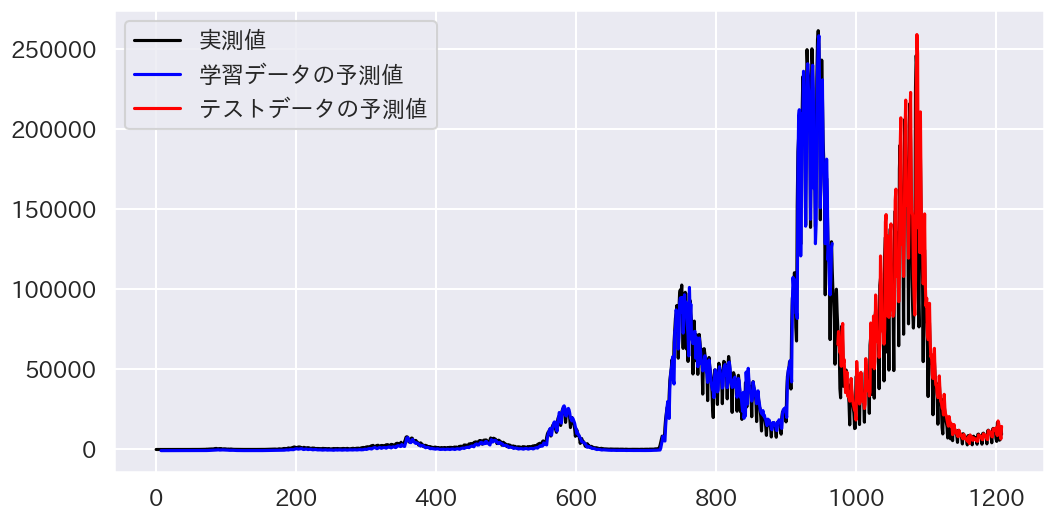

In [10]:
model = Sequential()
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(8))
model.add(Activation("relu"))
model.add(Dense(len(data.columns))) #出力層はデータ数に合わせる
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=100, batch_size=1)

#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-7])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])




import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()


Epoch 1/50
953/953 [==============================] - 19s 14ms/step - loss: 0.0069
Epoch 2/50
953/953 [==============================] - 12s 13ms/step - loss: 0.0043
Epoch 3/50
953/953 [==============================] - 13s 13ms/step - loss: 0.0038
Epoch 4/50
953/953 [==============================] - 12s 12ms/step - loss: 0.0033
Epoch 5/50
953/953 [==============================] - 13s 14ms/step - loss: 0.0031
Epoch 6/50
953/953 [==============================] - 13s 13ms/step - loss: 0.0026
Epoch 7/50
953/953 [==============================] - 14s 15ms/step - loss: 0.0025
Epoch 8/50
953/953 [==============================] - 13s 14ms/step - loss: 0.0022
Epoch 9/50
953/953 [==============================] - 13s 14ms/step - loss: 0.0021
Epoch 10/50
953/953 [==============================] - 13s 14ms/step - loss: 0.0022
Epoch 11/50
953/953 [==============================] - 13s 13ms/step - loss: 0.0022
Epoch 12/50
953/953 [==============================] - 13s 13ms/step - loss: 0.0021
E

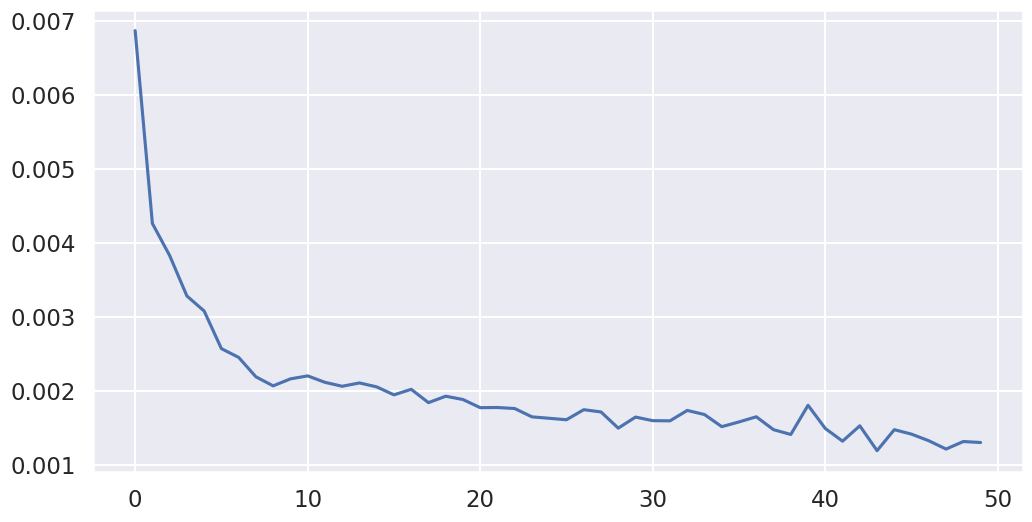

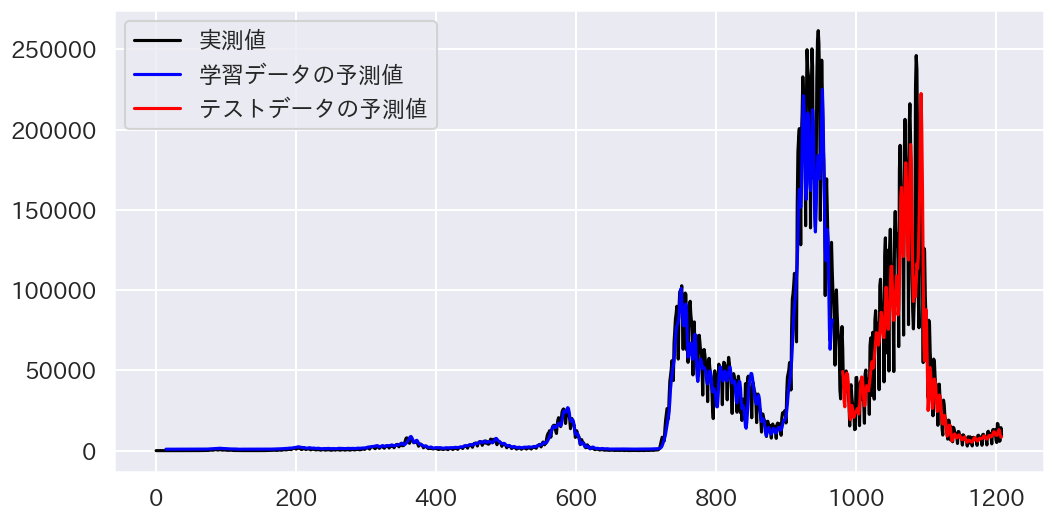

In [11]:
 #どれくらい過去まで見るか
look_back = 14


def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)


#モデルの定義
model = Sequential()
x = model.add(LSTM(15, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(5))
model.add(Activation("relu"))
model.add(Dense(1)) #出力層はデータ数に合わせる

optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer="adam")

history = model.fit(X_train, y_train, epochs=50, batch_size=1)

#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-14])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])


import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()


Epoch 1/100
953/953 [==============================] - 14s 10ms/step - loss: 0.0073
Epoch 2/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0033
Epoch 3/100
953/953 [==============================] - 9s 10ms/step - loss: 0.0030
Epoch 4/100
953/953 [==============================] - 10s 10ms/step - loss: 0.0028
Epoch 5/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0025
Epoch 6/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0025
Epoch 7/100
953/953 [==============================] - 11s 11ms/step - loss: 0.0022
Epoch 8/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0023
Epoch 9/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0022
Epoch 10/100
953/953 [==============================] - 10s 10ms/step - loss: 0.0022
Epoch 11/100
953/953 [==============================] - 9s 10ms/step - loss: 0.0022
Epoch 12/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0021
Epo

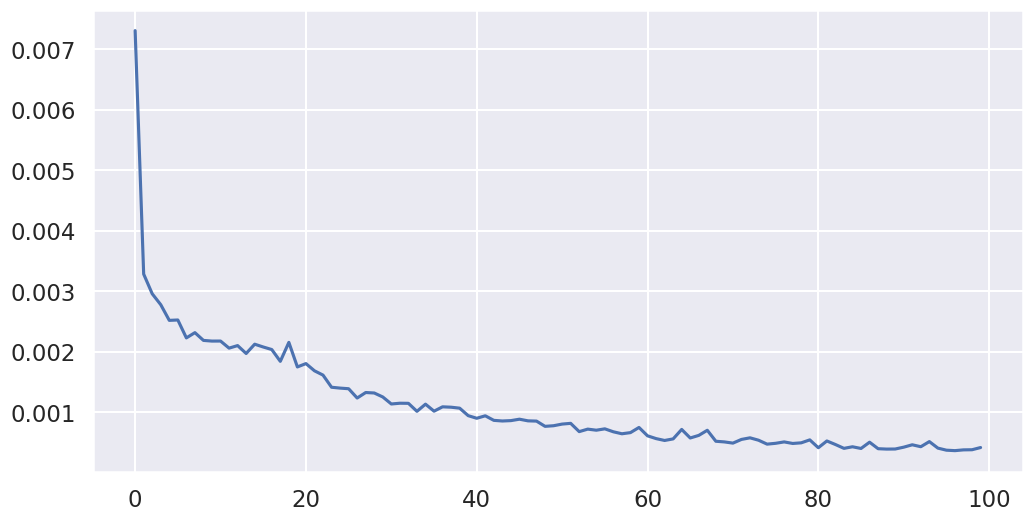

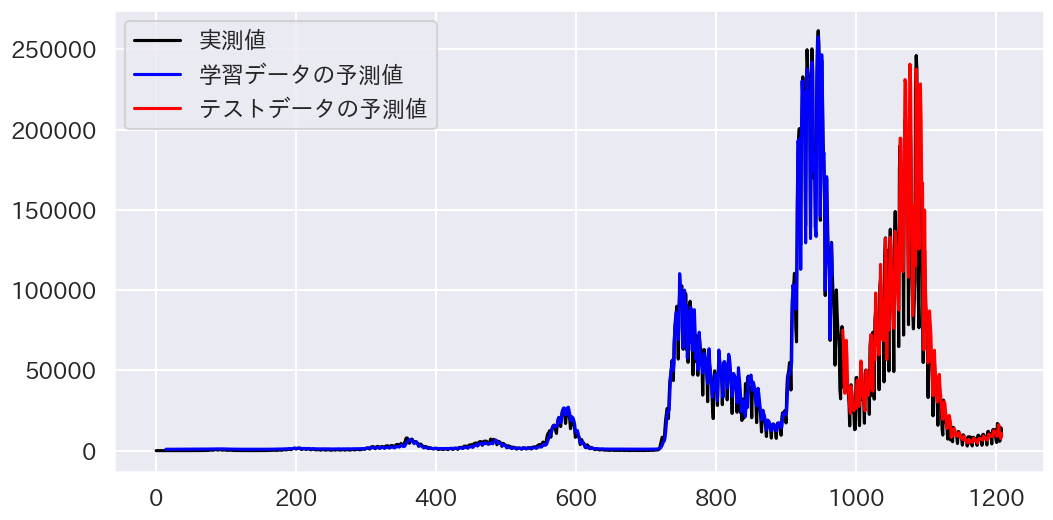

In [12]:
look_back = 14 #どれくらい過去まで見るか

def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)

#モデルの定義
model = Sequential()
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(8))
model.add(Activation("relu"))
model.add(Dense(len(data.columns))) #出力層はデータ数に合わせる
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=100, batch_size=1)


#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-14])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])



import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()


Epoch 1/100
953/953 [==============================] - 12s 9ms/step - loss: 0.0056
Epoch 2/100
953/953 [==============================] - 8s 8ms/step - loss: 0.0037
Epoch 3/100
953/953 [==============================] - 9s 10ms/step - loss: 0.0033
Epoch 4/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0028
Epoch 5/100
953/953 [==============================] - 8s 8ms/step - loss: 0.0024
Epoch 6/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0020
Epoch 7/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0023
Epoch 8/100
953/953 [==============================] - 8s 8ms/step - loss: 0.0022
Epoch 9/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0022
Epoch 10/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0021
Epoch 11/100
953/953 [==============================] - 8s 9ms/step - loss: 0.0022
Epoch 12/100
953/953 [==============================] - 9s 9ms/step - loss: 0.0020
Epoch 13/10

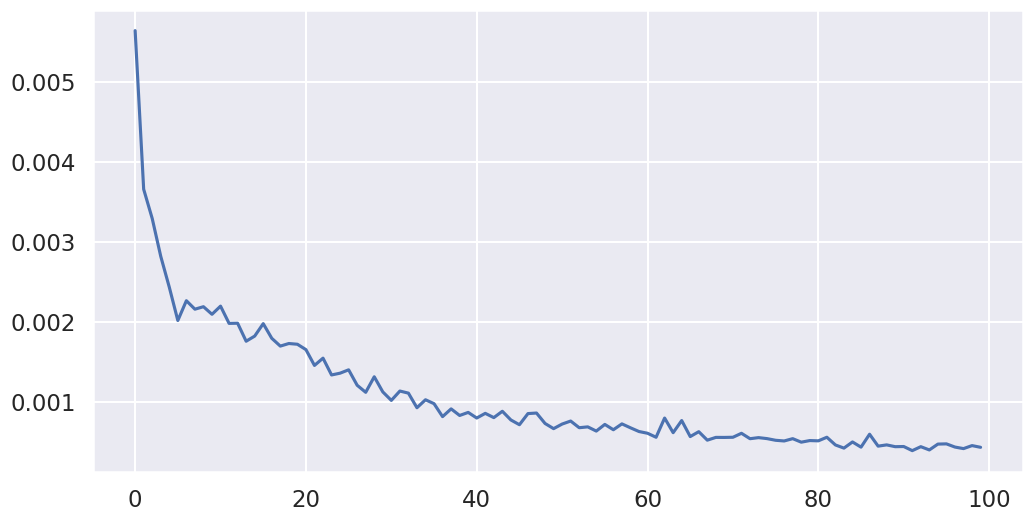

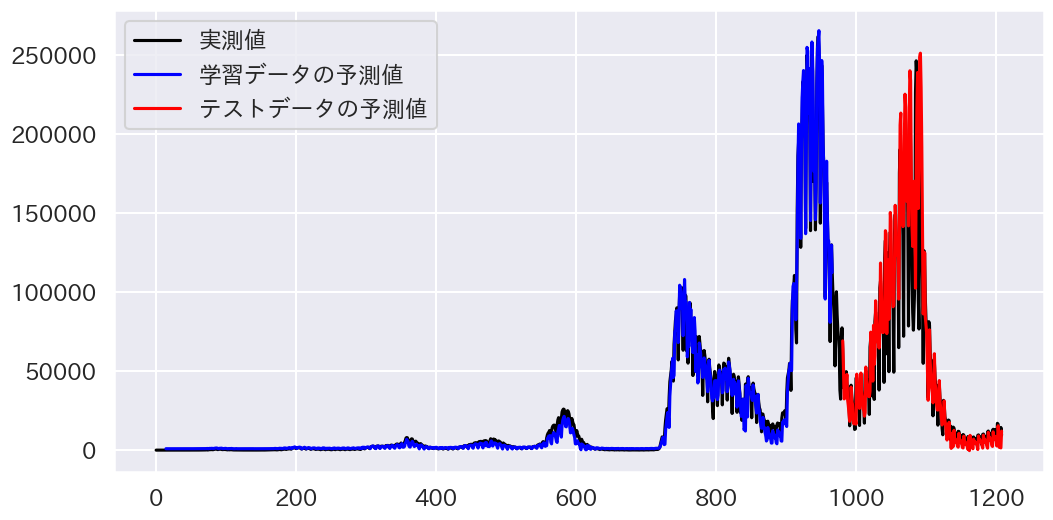

In [13]:
look_back = 14 #どれくらい過去まで見るか

def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)

#モデルの定義
model = Sequential()
x = model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10))
model.add(Activation("relu"))
model.add(Dense(len(data.columns))) #出力層はデータ数に合わせる
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=100, batch_size=1)

#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-14])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])





import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()


学習データ:
             0
722   0.023837
320   0.007683
777   0.257218
1008  0.137941
379   0.013468

テストデータ:
             0
1188  0.044136
1040  0.163742
593   0.067675
1039  0.294298
936   0.812891
モデルの評価
235/235 [==============================] - 2s 3ms/step - loss: 0.0572
Epoch 1/150
960/960 [==============================] - 10s 7ms/step - loss: 0.0353
Epoch 2/150
960/960 [==============================] - 6s 6ms/step - loss: 0.0349
Epoch 3/150
960/960 [==============================] - 7s 7ms/step - loss: 0.0347
Epoch 4/150
960/960 [==============================] - 5s 6ms/step - loss: 0.0348
Epoch 5/150
960/960 [==============================] - 6s 6ms/step - loss: 0.0348
Epoch 6/150
960/960 [==============================] - 6s 6ms/step - loss: 0.0348
Epoch 7/150
960/960 [==============================] - 6s 6ms/step - loss: 0.0348
Epoch 8/150
960/960 [==============================] - 7s 7ms/step - loss: 0.0347
Epoch 9/150
960/960 [==============================] - 5s 6ms/step - l

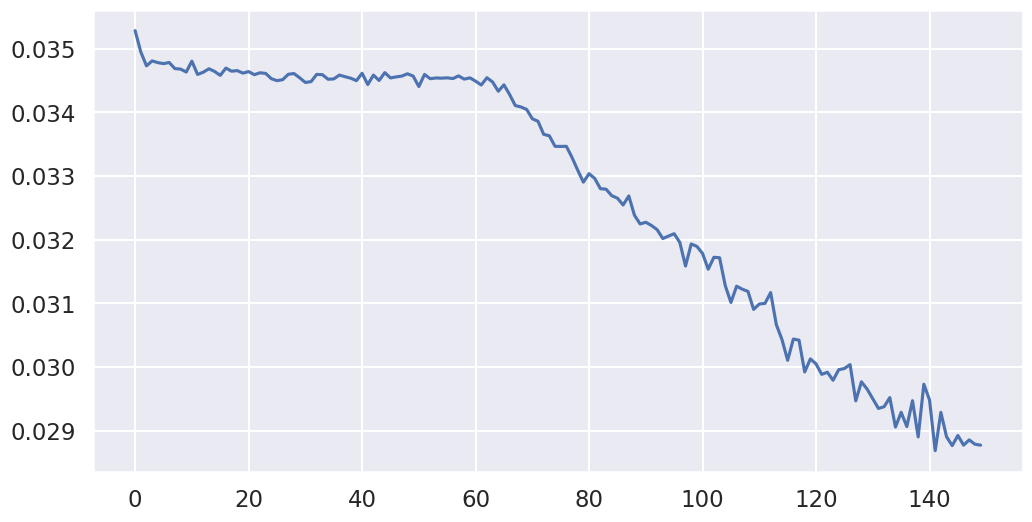

In [14]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータの分別
train_data, test_data = train_test_split(df_scale, test_size=0.2, shuffle=True)

print("学習データ:")
print(train_data[:5])
print("\nテストデータ:")
print(test_data[:5])


look_back = 7 #どれくらい過去まで見るか

def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)


model = Sequential()
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(8))
model.add(Dense(len(data.columns))) #出力層はデータ数に合わせる

#モデルの評価

model.compile(loss='mean_squared_error', optimizer='adam')
print("モデルの評価")
model.evaluate(X_test,y_test,batch_size=1)

history = model.fit(X_train, y_train, epochs=150, batch_size=1)

sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])




In [15]:
model.evaluate(X_test,y_test,batch_size=1)

235/235 [==============================] - 1s 3ms/step - loss: 0.0457


0.045711714774370193